In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pylab as plt
import matplotlib

## Point conditioning

In [10]:
def conditional(u, v, y_v, kernel, params=[1, 0.01]):
    cov_u = kernel(u, u, params)
    cov_v = kernel(v, v, params)
    cov_uv = kernel(u, v, params)
    
    cov_v_inv = np.linalg.pinv(cov_v)
    cov_T_uv = kernel(v, u, params)
    
    mu = cov_uv.dot(cov_v_inv).dot(y_v)
    sigma = cov_u - cov_uv.dot(cov_v_inv).dot(cov_T_uv)

    return(mu.squeeze(), sigma.squeeze())

In [11]:
def exponential_cov(u, v, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(u, v)**2)

In [12]:
v = np.arange(20,400,40)
y_v = [0,1,2,1,0,-1,-2,-1,0,1]

xpts = np.array(range(400))
mu, sigma = conditional(xpts, v, y_v, exponential_cov)

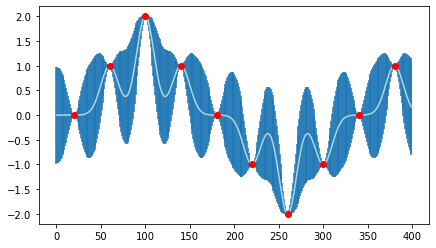

In [13]:
plt.figure(figsize=(7,4))
plt.errorbar(xpts, mu, yerr=np.diag(sigma), capsize=0, zorder=-1)
plt.plot(mu, color='lightblue')

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")

In [14]:
cp2 = la.sqrtm(sigma)

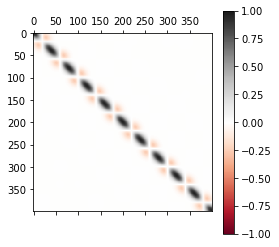

In [19]:
plt.matshow(sigma, vmin=-1, vmax=1, cmap='RdGy')
plt.colorbar()

In [17]:
samples = [mu + np.real(np.dot(cp2, np.random.normal(size=mu.shape[0]))) for _ in range(20)]

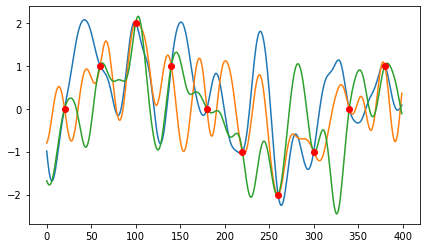

In [18]:
plt.figure(figsize=(7,4))
for s in samples[:3]:
    plt.plot(s)
for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")
plt.show()

## Spatial conditioning

In [25]:
def compute_cov_block(l, sdim):
    ar = np.zeros([sdim,sdim])
    
    for i in range(0, sdim, l):
            ar[i:i+l, i:i+l] = 1
            
    ar = ar.reshape(sdim//l, l, sdim).mean(axis=(1))
            
    return ar.reshape(sdim//l, sdim) / l

In [26]:
def conditional_s(sdim, l, y_v, kernel, params=[1, 0.01]):
    u = np.array(range(sdim))
    
    cov_u = kernel(u, u, params)
    A = compute_cov_block(l, sdim)
    cov_uv = np.dot(cov_u, A.T)
    cov_T_uv = cov_uv.T
    cov_v = np.linalg.multi_dot([A, cov_u, A.T])
    
    cov_v_inv = np.linalg.pinv(cov_v)
    
    mu = cov_uv.dot(cov_v_inv).dot(y_v)
    sigma = cov_u - cov_uv.dot(cov_v_inv).dot(cov_T_uv)

    return(mu.squeeze(), sigma.squeeze())

In [27]:
y = [0,1,2,1,0,-1,-2,-1,0,1]

In [28]:
mu_s, sigma_s = conditional_s(400, 40, [0,1,2,1,0,-1,-2,-1,0,1], exponential_cov, params=[1,0.01])

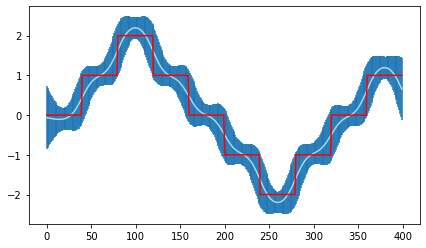

In [32]:
plt.figure(figsize=(7,4))
plt.errorbar(np.array(range(400)), mu_s, yerr=np.diag(sigma_s), capsize=0, zorder=-1)
plt.plot(mu_s, color='lightblue')
plt.plot(np.repeat(y, 40), color='red')

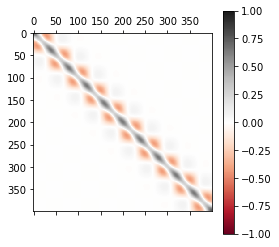

In [33]:
plt.matshow(sigma_s, vmin=-1, vmax=1, cmap='RdGy')
plt.colorbar()

In [39]:
# cp2_s = la.sqrtm(sigma_s)
cp2_s = la.cholesky(sigma_s + 0.0001*np.diag(np.ones(sigma_s.shape[0]))).T

In [46]:
samples_s = [mu_s + np.real(np.dot(cp2_s, np.random.normal(size=mu_s.shape[0]))) for _ in range(20)]

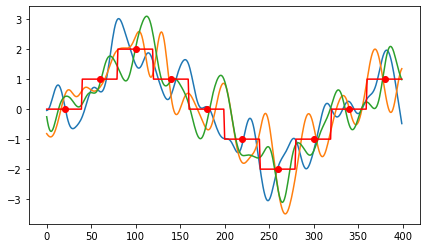

In [47]:
plt.figure(figsize=(7,4))
for s in samples_s[:3]:
    plt.plot(s)
for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")
plt.plot(np.repeat(y, 40), color='red')
plt.show()

## Comparison

In [49]:
A = compute_cov_block(40,400)

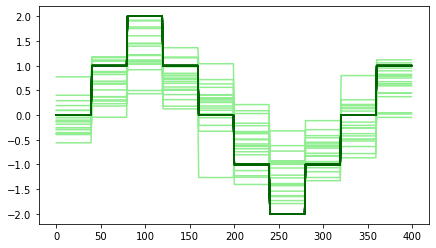

In [50]:
plt.figure(figsize=(7,4))
for s in samples:
    plt.plot(np.repeat(np.dot(A, s), 40), c='lightgreen')

for s in samples_s:
    plt.plot(np.repeat(np.dot(A, s), 40), c='darkgreen')